## Income Prediction Project

### Data:

The adult dataset collected by Barry Becker from the 1994 Census database. The dataset contains 48842 observations with some missing values. It contains 14 variables and the target variable. The variables included are as such:

Exploratory Variables:
- age (Integer): Age of person (>16)
- workclass (Categorical): type of work (ex. self-employed, private, gov)
- fnlwgt (Integer): final weight (the estimated amount of people represented by this instance)
- education (Categorical): Education level
- education-num (Integer): Education level in terms of numbers
- marital-status (Categorical): Current marital status (ex. Married, divorced, widowed)
- occupation (Categorical): Job title/industry
- relationship (Categorical): relationships with family (ex. wife, husband, not-in-family, own-child, unmarried)
- race (Categorical)
- sex (Categorical)
- capital-gain (Integer): an individual's capital gains
- captial-loss (Integer): an individual's capitals losses
- hours-per-week (Integer): hours worked per week (>0)
- native-country (Categorical): country of origin
<br><br>

Response Variable:
- income (Categorical): whether an individual makes more than 50K per year or less than 50K annually.


### Question:

How is time invested, age/experience, associated with income? This is the question we wish to explore in this project. We will create a model that predicts the binary label of income (>50K or <=50K/year) based on age, education level, hours per week, and marital-status.  The data will help us to train a logistic regression model to predict income of a person given their answers for the explanatory variables. By using age/hours worked per week as a proxy for experience, we will use these variable to explain how predicted income may change with these variables. Marital status may be somewhat connected to age so using this variable with an interaction term may help to make the predictions better. Finally education level is how we will judge 'time invested' into an industry. This question is focused on prediction to see if we are able to accurately predict the income based on our given explanatory variables. 

### Exploratory Data Analysis

In [2]:
# Import Packages
library(tidyverse)
library(repr)
library(readr)
library(broom)

Warning message:
“package ‘dplyr’ was built under R version 4.3.2”
Warning message:
“package ‘stringr’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [14]:
# Read data from web
url <- "https://archive.ics.uci.edu/static/public/2/adult.zip"
temp <- tempfile()
download.file(url, temp)
adult <- read_csv(unz(temp, "adult.data"))
adult_test <- read_csv(unz(temp, "adult.test"), skip = 1)
unlink(temp)

# Apply column names
colnames(adult) <- c("age", "workclass", "fnlwgt", "education","education_num",
                     "marital_status", "occupation", "relationship", "race", 
                     "sex", "capital_gain", "capital_loss", "hours_per_week",
                     "native_country", "income")

colnames(adult_test) <- c("age", "workclass", "fnlwgt", "education","education_num",
                     "marital_status", "occupation", "relationship", "race", 
                     "sex", "capital_gain", "capital_loss", "hours_per_week",
                     "native_country", "income")
head(adult)

Rows: 32560 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): State-gov, Bachelors, Never-married, Adm-clerical, Not-in-family, W...
dbl (6): 39, 77516, 13, 2174, 0, 40

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `0` -> `0...11`
• `0` -> `0...12`
Rows: 16280 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): Private, 11th, Never-married, Machine-op-inspct, Own-child, Black, ...
dbl (6): 25, 226802, 7, 0...11, 0...12, 40

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K


#### Data Cleaning

To investigate the chosen question, we will be using the following variables to predict the response (income):
- age
- education
- hours-per-week
- marital-status

Because our response is binary, we will also transform the column values from character to 0 and 1 where 
- 0 means income <=50K
- 1 means income >50K

Additionally, we should convert education and marital-status to factor variables. Additionally we will reduce the amount of factor levels for education in order to reduce model complexity. This is appropriate because for lower grade levels, there will be an insignificant difference between grade 4 and 5 education for example. We can group married into one category to generalize more easily. Grouping these categories also allowed for larger groups compared to the smaller ones that may be underrepresented in the model. After cleaning the data we can inspect the top 5 rows and view a summary of the columns.

In [21]:
# Select chosen explanatory variables
adult_clean <- adult %>% 
    select("age", "education", "hours_per_week", "marital_status", "income")

# Convert variables to factor
adult_clean <- adult_clean %>% 
    mutate(income = recode(income, 
                           "<=50K" = "0",
                           ">50K" = "1")) %>%
    mutate(education = recode(education, 
                           "Preschool" = "No-HS",
                           "1st-4th" = "No-HS", 
                           "5th-6th" = "No-HS",
                           "7th-8th" = "No-HS",
                           "9th" = "No-HS",
                           "10th" = "No-HS",
                           "11th" = "No-HS",
                           "12th" = "No-HS",
                           "Assoc-acdm" = "Associates",
                           "Assoc-voc" = "Associates")) %>% 
    mutate(marital_status = recode(marital_status,
                                   "Married-AF-spouse" = "Married",
                                   "Married-civ-spouse" = "Married",
                                   "Married-spouse-absent" = "Married")) %>%
    mutate(income = as.factor(income)) %>%
    mutate(education = as.factor(education)) %>%
    mutate(marital_status = as.factor(marital_status))

# Select chosen explanatory variables
adult_test_clean <- adult_test %>% 
    select("age", "education", "hours_per_week", "marital_status", "income")

# Convert variables to factor
adult_test_clean <- adult_test_clean %>% 
    mutate(income = recode(income, 
                           "<=50K." = "0",
                           ">50K." = "1")) %>%
    mutate(education = recode(education, 
                           "Preschool" = "No-HS",
                           "1st-4th" = "No-HS", 
                           "5th-6th" = "No-HS",
                           "7th-8th" = "No-HS",
                           "9th" = "No-HS",
                           "10th" = "No-HS",
                           "11th" = "No-HS",
                           "12th" = "No-HS",
                           "Assoc-acdm" = "Associates",
                           "Assoc-voc" = "Associates")) %>% 
    mutate(marital_status = recode(marital_status,
                                   "Married-AF-spouse" = "Married",
                                   "Married-civ-spouse" = "Married",
                                   "Married-spouse-absent" = "Married")) %>%
    mutate(income = as.factor(income)) %>%
    mutate(education = as.factor(education)) %>%
    mutate(marital_status = as.factor(marital_status))

head(adult_clean)
summary(adult_clean)

age,education,hours_per_week,marital_status,income
<dbl>,<fct>,<dbl>,<fct>,<fct>
50,Bachelors,13,Married,0
38,HS-grad,40,Divorced,0
53,No-HS,40,Married,0
28,Bachelors,40,Married,0
37,Masters,40,Married,0
49,No-HS,16,Married,0


      age               education     hours_per_week        marital_status 
 Min.   :17.00   HS-grad     :10501   Min.   : 1.00   Divorced     : 4443  
 1st Qu.:28.00   Some-college: 7291   1st Qu.:40.00   Married      :15417  
 Median :37.00   Bachelors   : 5354   Median :40.00   Never-married:10682  
 Mean   :38.58   No-HS       : 4253   Mean   :40.44   Separated    : 1025  
 3rd Qu.:48.00   Associates  : 2449   3rd Qu.:45.00   Widowed      :  993  
 Max.   :90.00   Masters     : 1723   Max.   :99.00                        
                 (Other)     :  989                                        
 income   
 0:24719  
 1: 7841  
          
          
          
          
          

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


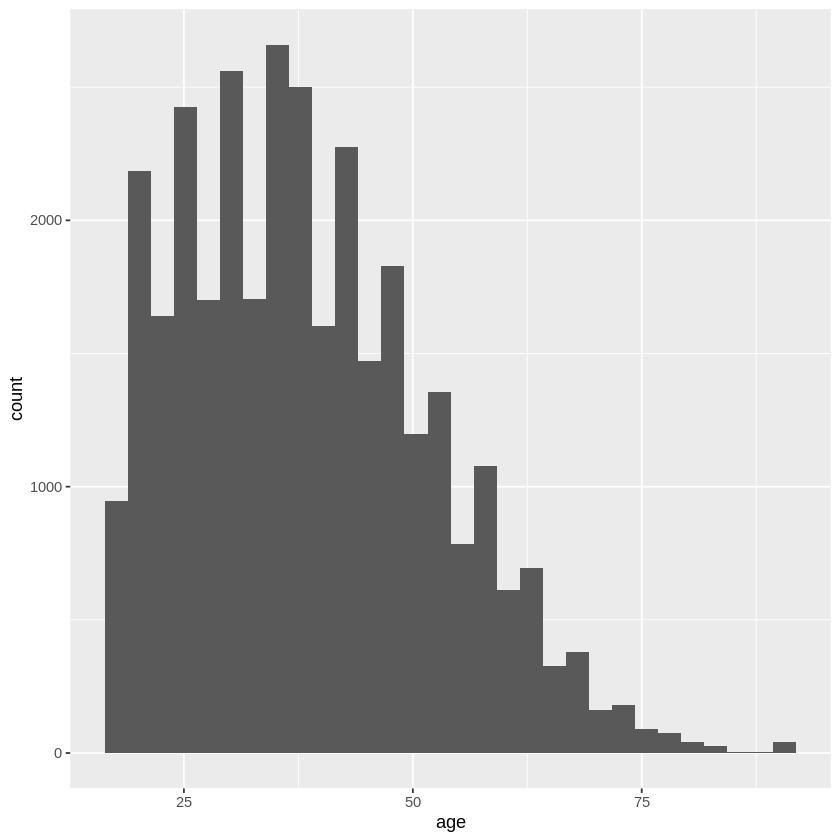

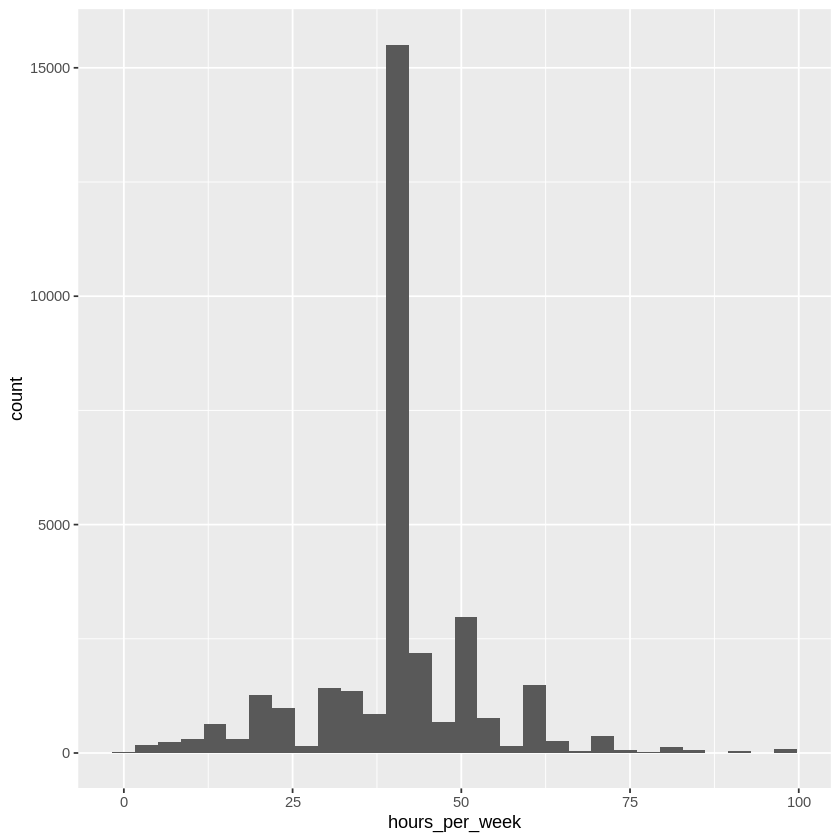

In [5]:
age_dist <- ggplot(adult_clean) +
                    geom_histogram(aes(age))
hrly_dist <- ggplot(adult_clean) +
                    geom_histogram(aes(hours_per_week))

age_dist
hrly_dist

### Check the packaging & inspect top and bottom of data

In [6]:
str(adult_clean)

tibble [32,560 × 5] (S3: tbl_df/tbl/data.frame)
 $ age           : num [1:32560] 50 38 53 28 37 49 52 31 42 37 ...
 $ education     : Factor w/ 8 levels "Associates","Bachelors",..: 2 4 6 2 5 6 4 5 2 8 ...
 $ hours_per_week: num [1:32560] 13 40 40 40 40 16 45 50 40 80 ...
 $ marital_status: Factor w/ 5 levels "Divorced","Married",..: 2 1 2 2 2 2 2 3 2 2 ...
 $ income        : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 2 2 2 2 ...


In [7]:
head(adult_clean)
tail(adult_clean)

age,education,hours_per_week,marital_status,income
<dbl>,<fct>,<dbl>,<fct>,<fct>
50,Bachelors,13,Married,0
38,HS-grad,40,Divorced,0
53,No-HS,40,Married,0
28,Bachelors,40,Married,0
37,Masters,40,Married,0
49,No-HS,16,Married,0


age,education,hours_per_week,marital_status,income
<dbl>,<fct>,<dbl>,<fct>,<fct>
22,Some-college,40,Never-married,0
27,Associates,38,Married,0
40,HS-grad,40,Married,1
58,HS-grad,40,Widowed,0
22,HS-grad,20,Never-married,0
52,HS-grad,40,Married,1


While inspecting the histograms and data instances, we can see that age is right-skewed and people tend to be younger than 50. While for hours_per_week, most of the data is set at 40 hours per weak, with very thin tails.

### Visualization
Considering societal expectations and industry trends, we would expect that as age increases, income will be greater. Additionally based on education level, we expect that as people gain higher levels of education, their income will increase. Therefore side by side boxplots comparing ages of different education levels based on income will help to see any underlying trends within the data. 

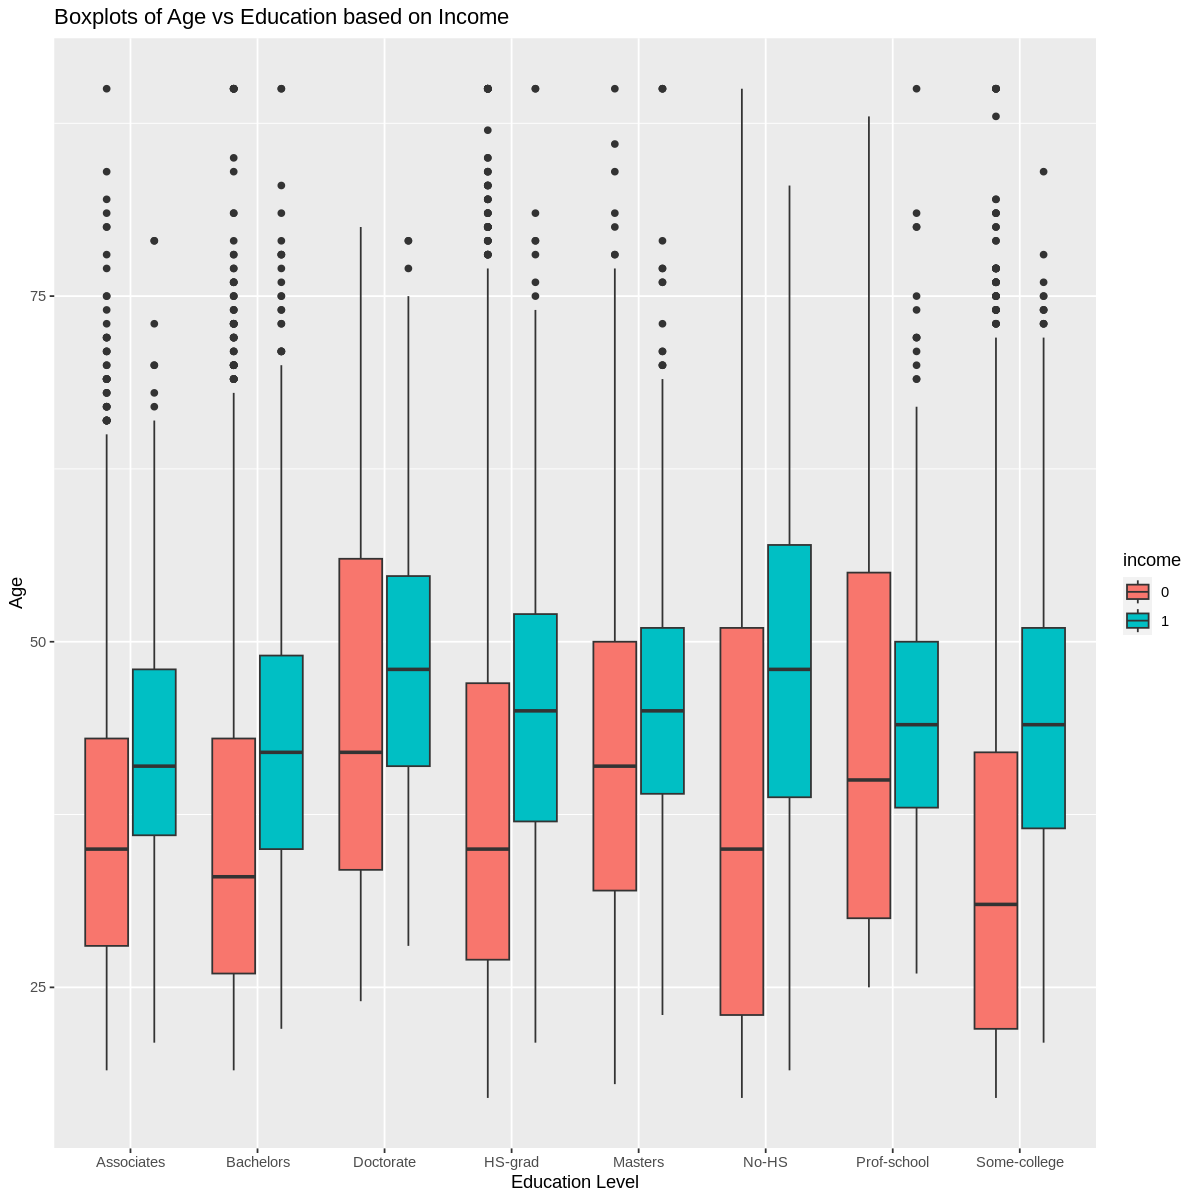

In [8]:
options(repr.plot.width = 10, repr.plot.height =10)

boxplot <- ggplot(adult_clean, aes(education, age, fill = income)) +
                geom_boxplot() +
                ggtitle("Boxplots of Age vs Education based on Income") +
                labs(x = "Education Level", y = "Age")
boxplot    

This plot demonstrates that at different levels of education there is some amount of association between age and income. We can see that the ages of those in the higher income category is generally greater than those in the lower income category (i.e. blue bars are higher than red bars). The variances of the age for high income category is generally smaller than the lower income category. It is hard to determine from these boxplots whether there is a significant difference between different education level. There are some visual similarities, such as associates and bachelors degrees. This visualization helps to show the difference in ages based on income at different education levels, showing that there is some association between the variables that we can show in a linear model. We may be able to correctly predict income with additional variables, because the spread for each boxplot is not within others. There is some overlap however which may cause some problems, by using other variables, we can train the model to improve the prediction accuracy.

### Methods and Plan

Because we are dealing with a binary response variable, we should consider modelling this data with a classifier model. The classifier we have decided to implement is a logistic regression model. This is an appropriate method because it allows us to use both our numerical and categorical variables. Additionally, it is an interpretable model because of its somewhat linear equation which allows us to clearly identify which variables are have the most influence on the prediction. We can also view uncertainty within the model by viewing the probability and can therefore be more or less confident with our predictions. For logistic regression, we must make standard assumptions such as independence of observations and large sample size. There are additional assumptions we must make about the model including little to no multicollinearity between our variables and linearity of regressor variables and log odds. If the model does not satisfy these assumptions then the model may not correctly predict the target variable. A potential limitation of this type of classifier is that the decision boundary that logistic regression calculates is linear, which means it cannot correctly preidct the target variable with a complex decision boundary. 

### Implementation of a proposed model

In [9]:
model <- glm(income ~., data = adult_clean, family = "binomial")

In [10]:
tidy(model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-4.77307786,0.116908117,-40.8276001,0.000000e+00
age,0.02789118,0.001412194,19.7502432,7.983250e-87
educationBachelors,0.80087543,0.062893718,12.7337906,3.837464e-37
educationDoctorate,1.86879745,0.143641226,13.0101747,1.070969e-38
educationHS-grad,-0.76163640,0.060599798,-12.5682993,3.154363e-36
educationMasters,1.25874049,0.079395877,15.8539780,1.319568e-56
educationNo-HS,-1.95898583,0.087812282,-22.3087908,3.035921e-110
educationProf-school,1.86352817,0.124404581,14.9795784,9.984847e-51
educationSome-college,-0.25684465,0.063055787,-4.0732922,4.635321e-05


In [38]:
preds <- predict(model, adult_test_clean, type = "response")
head(tidy(preds))

Warning message:
“'tidy.numeric' is deprecated.
See help("Deprecated")”


names,x
<chr>,<dbl>
1,0.315578161
2,0.348770488
3,0.392924948
4,0.017104201
5,0.004932025
6,0.019528413


In [43]:
head(tibble(preds, adult_test_clean$income), 10)

preds,adult_test_clean$income
<dbl>,<fct>
0.315578161,0
0.348770488,1
0.392924948,1
0.017104201,0
0.004932025,0
0.019528413,0
0.875323133,1
0.027900126,0
0.055756728,0
